# ML Medical Records

## Part 1: Load From SQL

In [69]:
from getpass import getpass
import kardiasclean
import pandas as pd

# Connect to database with password
password = getpass('Enter database password')
host = "kardias-test.cvj7xeynbmtt.us-east-1.rds.amazonaws.com"
pgm = kardiasclean.PostgresManager("kardias", password, host)

In [70]:
# Query
a = "surgical_procedures_map"
b = "surgical_procedures"
df = pgm.read_query(f"""
        SELECT * FROM
        patients as pat
        JOIN {a} as a
        ON a.patient_id = pat.patient_id
        JOIN {b} as b
        ON b.token = a.token;
    """
)
print(df.columns.values)
df = df.T.groupby(level=0).first().T
df

['patient_id' 'gender' 'state' 'municipality' 'altitude' 'age' 'weight_kg'
 'height_cm' 'appearance' 'cx_previous' 'date_birth' 'date_procedure'
 'rachs' 'stay_days' 'expired' 'patient_id' 'token' 'token' 'procedure'
 'keywords']


,age,altitude,appearance,cx_previous,date_birth,date_procedure,expired,gender,height_cm,keywords,municipality,patient_id,procedure,rachs,state,stay_days,token,weight_kg
0,3942,2726,Normal,0,2001-08-22,2012-04-08,0,0,134.0,CIA Reparacion parche,Huixquilucan,0,Reparacion de CIA parche,1.0,Estado de México,2.0,SRPRSNPRX,35.0
1,3202,2741,Desnutrido,0,2003-09-19,2012-11-08,0,1,117.0,CIA Reparacion parche,Timilpan,1,Reparacion de CIA parche,1.0,Estado de México,2.0,SRPRSNPRX,18.0
2,3147,2240,Normal,0,2003-11-21,2012-08-18,0,0,120.0,CIA Reparacion parche,Coyoacán,2,Reparacion de CIA parche,1.0,Ciudad de México,2.0,SRPRSNPRX,22.0
3,4005,2220,Normal,0,2001-10-07,2012-08-25,0,0,147.0,CIA Reparacion parche,Nezahualcoyotl,3,Reparacion de CIA parche,1.0,Estado de México,2.0,SRPRSNPRX,42.0
4,5289,2373,Normal,0,1997-12-22,2012-01-09,0,0,157.0,CIA Reparacion parche,Alvaro Obregón,4,Reparacion de CIA parche,1.0,Ciudad de México,3.0,SRPRSNPRX,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,14,1980,Normal,0,2022-10-10,2022-10-24,0,1,50.0,Reparacion aortico arco avance tecnica,Atotonilco el Grande,1035,Reparacion de arco aortico con tecnica de avan...,4.0,Hidalgo,-44214.0,RPRSNRTKRKFNSTKNK,3.23
1659,14,1980,Normal,0,2022-10-10,2022-10-24,0,1,50.0,Exploracion aortica valvula,Atotonilco el Grande,1035,Exploracion de valvula aortica,4.0,Hidalgo,-44214.0,AKSPLRSNRTKFLFL,3.23
1660,67,2100,Desnutrido,0,2022-08-24,2022-10-31,0,1,53.5,Correccion Fallot parche tetralogia transanula...,Iztapalapa,1037,Correccion de tetralogia de Fallot ventriculot...,3.0,Ciudad de México,-44220.0,KRXNFLTPRXTTRLJTRNSNLRFNTRKLTLM,3.8
1661,67,2100,Desnutrido,0,2022-08-24,2022-10-31,0,1,53.5,Cierre comunicacion interauricular parche,Iztapalapa,1037,Cierre de comunicacion interauricular parche,3.0,Ciudad de México,-44220.0,SRKMNKSNNTRRKLRPRX,3.8


In [71]:
# Get dataframe from sql
columns = [
    "patient_id",
    "procedure",
    "gender", 
    "age", 
    "weight_kg", 
    "height_cm", 
    "stay_days"
]
df = df[columns]
df.count()

patient_id    1663
procedure     1663
gender        1663
age           1663
weight_kg     1663
height_cm     1663
stay_days     1663
dtype: int64

<AxesSubplot:xlabel='weight_kg', ylabel='height_cm'>

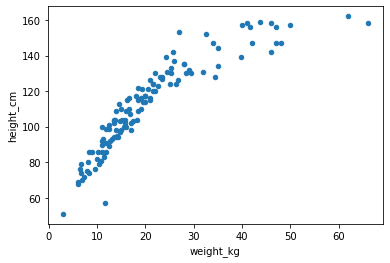

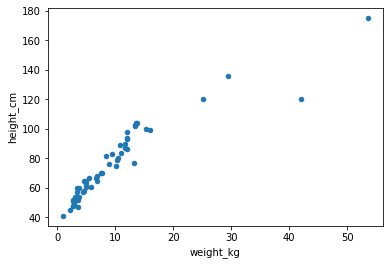

In [72]:
# Plot data
import matplotlib.pyplot as plt

df[df['procedure'] == 'Reparacion de CIA parche'].plot(kind='scatter', x='weight_kg', y='height_cm')
df[df['procedure'] == 'Cierre quirurgico de conducto arterioso'].plot(kind='scatter', x='weight_kg', y='height_cm')

## Part 2: ML Pre-Processing

1. Bin data by frequency.
2. Use only high frequency values.
3. Encode data and merge with original.

In [74]:
# Bin
bins = kardiasclean.perform_binning_quantile(df, 'procedure', quantile=0.85)
bins

Other                                                                       584
Reparacion de CIA parche                                                    123
Reparacion de CIV parche                                                    122
Cierre quirurgico de PCA                                                    120
Cierre quirurgico de conducto arterioso                                      54
                                                                           ... 
Exploracion de la valvula pulmonar                                            3
Reparacion de doble salida de ventriculo derecho con tunel intracardiaco      3
Exploracion de tabique interventricular                                       3
Cierre de hendidura mitral                                                    3
Plastia de la valvula aortica                                                 3
Name: procedure, Length: 93, dtype: int64

In [75]:
low, high = kardiasclean.perform_frequency_split_quantile(df['procedure'], 0.95)
high

Reparacion de CIA parche                                                       123
Reparacion de CIV parche                                                       122
Cierre quirurgico de PCA                                                       120
Cierre quirurgico de conducto arterioso                                         54
Reparacion de Tetralogia de Fallot no ventriculotomia no parche transanular     45
Procedimiento de Fontan conducto extracardioco no fenestrado                    32
Cierre de comunicacion interventricular parche                                  32
Procedimiento de Glenn bidireccional                                            29
Reseccion de membrana subaortica                                                26
Cierre de comunicacion interauricular parche                                    17
Reparacion de estenosis aortica subvalvular                                     16
Reparacion de Canal AV completo                                                 16
Liga

In [76]:
# Print eval
evaluation = kardiasclean.evaluate_distribution(high, low)
print(evaluation)

Number of high frequency data: 858
Number of low frequency data: 805
--------------------
Total Number of data: 1663.
Percentage of high data: 51.59%
Percentage of low data: 48.41%
--------------------
Summary
--------------------
From 1663 data, 37 account for 51.59% of the total count.



In [78]:
# Get only high frequency values from original df
high_freq_df = df[df['procedure'].isin(high.index)]
# save to csv
high_freq_df.head()

,patient_id,procedure,gender,age,weight_kg,height_cm,stay_days
0,0,Reparacion de CIA parche,0,3942,35.0,134.0,2.0
1,1,Reparacion de CIA parche,1,3202,18.0,117.0,2.0
2,2,Reparacion de CIA parche,0,3147,22.0,120.0,2.0
3,3,Reparacion de CIA parche,0,4005,42.0,147.0,2.0
4,4,Reparacion de CIA parche,0,5289,40.0,157.0,3.0


In [79]:
# encode selected data
encoded_df = kardiasclean.perform_matrix_encoding(high_freq_df['procedure'], high_freq_df['patient_id'])
encoded_df.head()

,patient_id,procedure_Reparacion de CIA parche,procedure_Reparacion de CIV parche,procedure_Reparacion de estenosis aortica subvalvular,procedure_Cierre quirurgico de PCA,procedure_Reparacion de CIA primario,procedure_Reparacion de Tetralogia de Fallot no ventriculotomia no parche transanular,procedure_Reparacion de Canal AV completo,procedure_Reparacion de comunicacion interventricular,procedure_Reparacion de arco aortico Avance de aorco aortico,...,procedure_Procedimiento de Fontan extracardiaco no fenestrado,procedure_Ligadura de conducto arterioso,procedure_Cierre de comunicacion interventricular parche,procedure_Cierre de comunicacion interauricular parche,procedure_Septectomia atrial,procedure_Cierre de comunicacion interauricular ostium secundum,procedure_Correccion de tetralogia de Fallot no ventriculotomia no parche transanular,procedure_Reparacion de arco aortico con tecnica de avance aortico,procedure_Correccion de Tetralogia de Fallot no parche transanular no ventriculotomia,procedure_Cierre de comunicacion interventricular perimembranosa
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# merge encoded with original 
merged_df = pd.merge(high_freq_df, encoded_df)
merged_df = merged_df.drop("procedure", axis=1)
merged_df.head()

,patient_id,gender,age,weight_kg,height_cm,stay_days,procedure_Reparacion de CIA parche,procedure_Reparacion de CIV parche,procedure_Reparacion de estenosis aortica subvalvular,procedure_Cierre quirurgico de PCA,...,procedure_Procedimiento de Fontan extracardiaco no fenestrado,procedure_Ligadura de conducto arterioso,procedure_Cierre de comunicacion interventricular parche,procedure_Cierre de comunicacion interauricular parche,procedure_Septectomia atrial,procedure_Cierre de comunicacion interauricular ostium secundum,procedure_Correccion de tetralogia de Fallot no ventriculotomia no parche transanular,procedure_Reparacion de arco aortico con tecnica de avance aortico,procedure_Correccion de Tetralogia de Fallot no parche transanular no ventriculotomia,procedure_Cierre de comunicacion interventricular perimembranosa
0,0,0,3942,35.0,134.0,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TODO: Scale Values (NEED TO COMPLETE DATA CLEANING FIRST!)
# import scikitlearn scaler, etc.

## Part 7: Machine Learning

In [ ]:
# TODO: ML
# import keras, scikitlearn, etc.